task 1

In [21]:
import pandas as pd
from pygooglenews import GoogleNews
from datetime import date
from dateutil.relativedelta import relativedelta
import time

def fetch_nvidia_headlines_clean():
    gn = GoogleNews(lang='en', country='US')
    
    today = date.today()
    current_date = today
    one_year_ago = today - relativedelta(years=2)
    
    all_articles = []

    print(f"Starting scrape for 'news_raw.csv'...")

    while current_date > one_year_ago:
        prev_date = current_date - relativedelta(months=1)
        
        start_str = prev_date.strftime('%Y-%m-%d')
        end_str = current_date.strftime('%Y-%m-%d')
        
        try:
            search = gn.search('Nvidia', from_=start_str, to_=end_str)
            entries = search['entries']
            
            for entry in entries:
                article_data = {
                    'source': entry.get('source', {}).get('title', 'Unknown'),
                    'headline': entry.get('title', ''),
                    'pubdate': entry.get('published', '')
                }
                all_articles.append(article_data)
                
        except Exception as e:
            print(f"Error: {e}")

        current_date = prev_date
        time.sleep(1) 

    if all_articles:
        df = pd.DataFrame(all_articles)
        
        df = df[['source', 'headline', 'pubdate']]
        
        df.drop_duplicates(subset=['headline'], inplace=True)
        
        df.to_csv('news_raw.csv', index=False)
        
        print("-" * 30)
        print(f"✅ Success! Saved {len(df)} headlines to 'news_raw.csv'")
    else:
        print("No articles found.")

if __name__ == "__main__":
    fetch_nvidia_headlines_clean()

Starting scrape for 'news_raw.csv'...
------------------------------
✅ Success! Saved 2328 headlines to 'news_raw.csv'


Task 2: XML Structure Understanding

1.) the tag used to get the article is h3

2.) Each item corresponds to one news article, blog post, update, or announcement

3.) Written in XML with strict, predictable tags.

Uses predefined elements like channel, item, title, link, pubDate.

In [22]:
import pandas as pd
import numpy as np

df = pd.read_csv("news_raw.csv")

df["pubdate"] = pd.to_datetime(df["pubdate"], utc=True).dt.date

df["headline_length"] = df["headline"].astype(str).apply(len)

df.to_csv("news_cleaned.csv", index=False)

print("Cleaned news data saved to news_cleaned.csv")


Cleaned news data saved to news_cleaned.csv


Task 4

In [23]:
import yfinance as yf
import pandas as pd

ticker = "NVDA"

stock = yf.download(ticker, period="2y")

stock_data = stock[["Open", "High", "Low", "Close", "Volume"]]

stock_data.columns = stock_data.columns.get_level_values(0)

stock_data = stock_data.reset_index()

stock_data.to_csv("stock_data.csv", index=False)

print("Stock price data saved to stock_data.csv")



[*********************100%***********************]  1 of 1 completed

Stock price data saved to stock_data.csv


Task 5


Which dates in your news data are non-trading days?
20-12-25,21-12-25,27-12-25,28-12-2025

Why does the stock market not trade on those days?
becuase it was a weekend and the stock market is off on weekends

How many news articles fall on non-trading days?
10 news article were uploaded on NVDA

In [24]:
news_df = pd.read_csv("news_cleaned.csv")
stock_df = pd.read_csv("stock_data.csv")

news_df["pubdate"] = pd.to_datetime(news_df["pubdate"])
stock_df["Date"] = pd.to_datetime(stock_df["Date"])

merged_df = pd.merge(
    news_df,
    stock_df,
    left_on="pubdate",
    right_on="Date",
    how="left"
)

merged_df["is_trading_day"] = merged_df["Open"].notna()
merged_df.to_csv("merged_midterm_data.csv", index=False)


Task 7

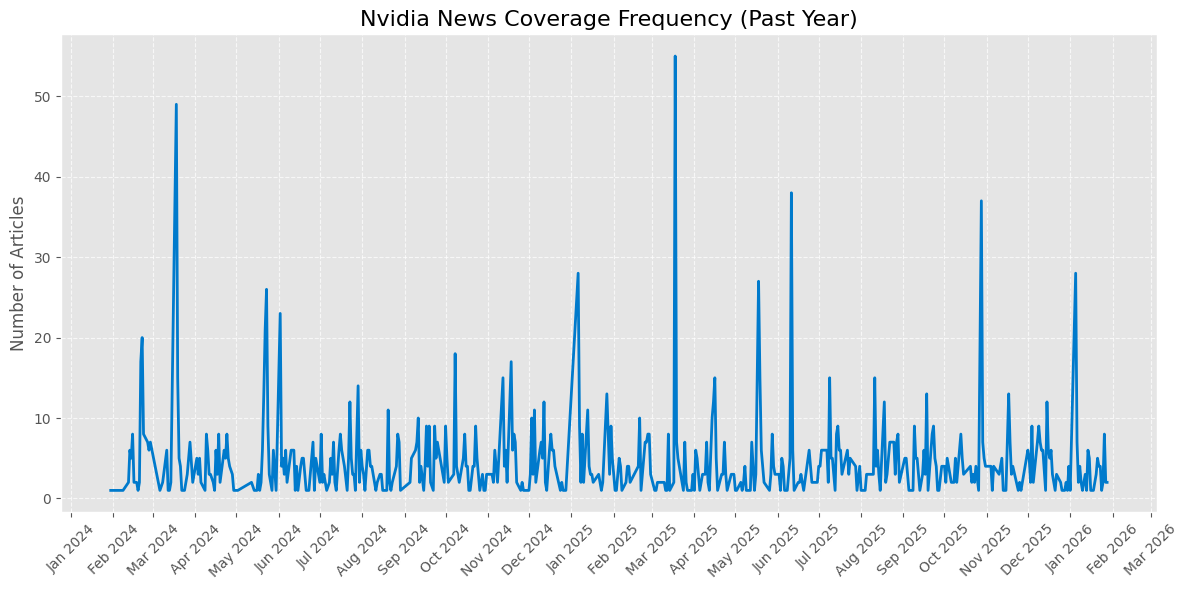

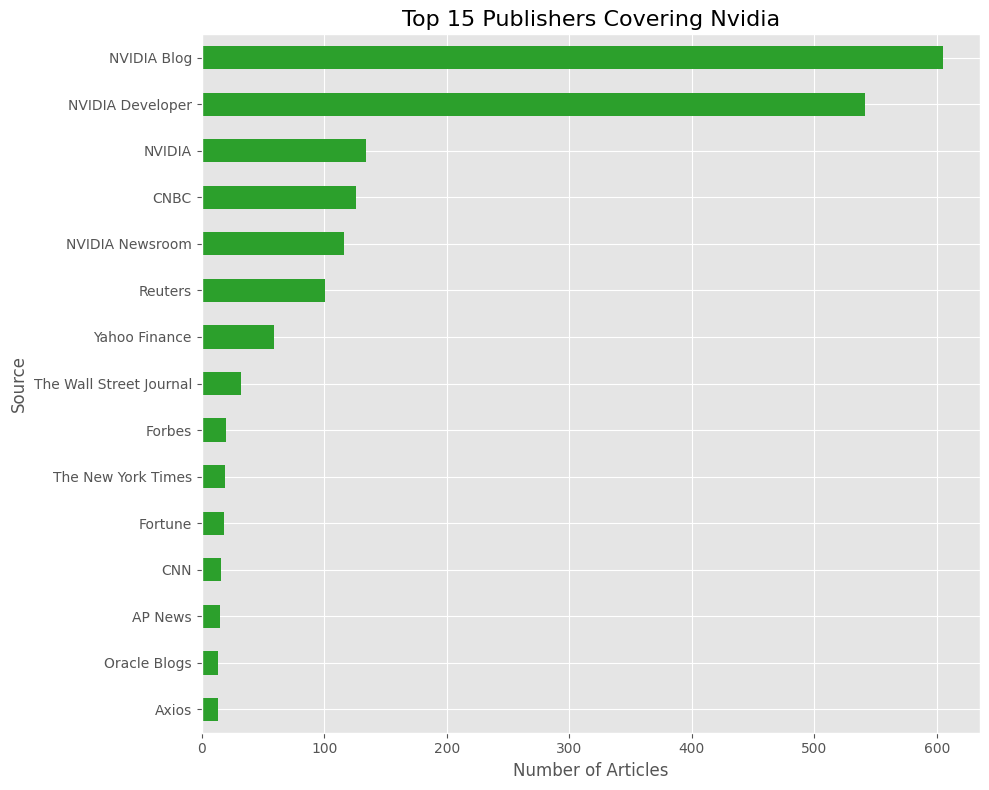

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Load Data
try:
    df = pd.read_csv("news_cleaned.csv")
except FileNotFoundError:
    print("File not found! using 'news_raw.csv' instead based on previous step.")
    df = pd.read_csv("news_raw.csv")

df['pubdate'] = pd.to_datetime(df['pubdate'], utc=True)

df['date_only'] = df['pubdate'].dt.date

plt.style.use('ggplot') 

daily_counts = df.groupby('date_only').size()

plt.figure(figsize=(12, 6))

plt.plot(daily_counts.index, daily_counts.values, color='#007acc', linewidth=2)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.title("Nvidia News Coverage Frequency (Past Year)", fontsize=16)
plt.ylabel("Number of Articles", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

top_sources = df['source'].value_counts().head(15)

plt.figure(figsize=(10, 8))

top_sources.sort_values().plot(kind='barh', color='#2ca02c')

plt.title("Top 15 Publishers Covering Nvidia", fontsize=16)
plt.xlabel("Number of Articles", fontsize=12)
plt.ylabel("Source", fontsize=12)
plt.tight_layout()
plt.show()

Sentiment Analysis

In [26]:
import pandas as pd
from transformers import pipeline

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="ProsusAI/finbert"
)

df = pd.read_csv("merged_midterm_data.csv")

HEADLINE_COLUMN = "headline"
headlines = df[HEADLINE_COLUMN].astype(str).tolist()

results = sentiment_pipeline(headlines)

df["sentiment"] = [r["label"].lower() for r in results]
df["sentiment_confidence"] = [r["score"] for r in results]

df.to_csv("news_with_sentiment.csv", index=False)

print("Sentiment analysis completed. Saved to news_with_sentiment.csv")

Device set to use cpu


Sentiment analysis completed. Saved to news_with_sentiment.csv


Model Training

In [27]:
import pandas as pd
import yfinance as yf
import numpy as np
from xgboost import XGBClassifier 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

df_news = pd.read_csv("news_with_sentiment.csv")

sentiment_map = {"positive": 1, "neutral": 0, "negative": -1}
df_news["sentiment_score"] = (
    df_news["sentiment"].str.lower().map(sentiment_map) * df_news["sentiment_confidence"]
)

df_news["pubdate"] = pd.to_datetime(df_news["pubdate"], utc=True).dt.tz_localize(None).dt.normalize()

daily_news = df_news.groupby("pubdate").agg({
    "sentiment_score": ["mean", "count"]
}).reset_index()

daily_news.columns = ["Date", "sentiment_mean", "news_count"]

ticker = "NVDA"
stock = yf.download(ticker, period="2y", progress=False)
if isinstance(stock.columns, pd.MultiIndex):
    stock.columns = stock.columns.get_level_values(0)

stock = stock.reset_index()
stock["Date"] = pd.to_datetime(stock["Date"]).dt.tz_localize(None).dt.normalize()

merged = pd.merge(daily_news, stock, on="Date", how="inner")
merged = merged.sort_values("Date")
merged["next_close"] = merged["Close"].shift(-1)
merged["target"] = (merged["next_close"] > merged["Close"]).astype(int)

final_df = merged.dropna().reset_index(drop=True)
final_df.to_csv("final_model_data.csv", index=False)
print("Final model data saved to final_model_data.csv")

X = final_df[["sentiment_mean", "news_count", "Open", "Close", "Volume"]]
y = final_df["target"]

n_splits = max(2, min(5, len(final_df) // 10))
tscv = TimeSeriesSplit(n_splits=n_splits)

results = []

print(f"Training on {len(final_df)} rows with {n_splits} folds...")

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    if y_train.nunique() < 2: continue

    rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42, class_weight="balanced")
    rf.fit(X_train, y_train)
    rf_preds = rf.predict(X_test)
    rf_probs = rf.predict_proba(X_test)[:, 1]

    xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.05, eval_metric='logloss', random_state=42)
    xgb.fit(X_train, y_train)
    xgb_preds = xgb.predict(X_test)
    xgb_probs = xgb.predict_proba(X_test)[:, 1]

    def get_metrics(y_true, pred, prob, model_name):
        return {
            "fold": fold,
            "model": model_name,
            "accuracy": accuracy_score(y_true, pred),
            "precision": precision_score(y_true, pred, zero_division=0),
            "recall": recall_score(y_true, pred, zero_division=0),
            "f1": f1_score(y_true, pred, zero_division=0),
            "roc_auc": roc_auc_score(y_true, prob) if len(set(y_true)) > 1 else 0.5
        }

    results.append(get_metrics(y_test, rf_preds, rf_probs, "RandomForest"))
    results.append(get_metrics(y_test, xgb_preds, xgb_probs, "XGBoost"))

results_df = pd.DataFrame(results)
results_df.to_csv("experiment_results_comparison.csv", index=False)
print("Experiment results saved to 'experiment_results_comparison.csv'")

summary = results_df.groupby("model").mean(numeric_only=True).drop(columns="fold")
print("\n--- Model Performance Comparison ---")
print(summary)
summary.to_csv("final_model_summary.csv")
print("Final model summary saved to 'final_model_summary.csv'")

Final model data saved to final_model_data.csv
Training on 436 rows with 5 folds...
Experiment results saved to 'experiment_results_comparison.csv'

--- Model Performance Comparison ---
              accuracy  precision    recall        f1   roc_auc
model                                                          
RandomForest  0.513889   0.536964  0.456985  0.420117  0.516181
XGBoost       0.500000   0.604627  0.510148  0.435884  0.533999
Final model summary saved to 'final_model_summary.csv'
